In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from copy import deepcopy
from sklearn.metrics import make_scorer
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import KFold

In [3]:
import alexs_models
from alexs_models.imports import *

# Data Cleaning

## Format Dependent Variables

In [4]:
# NUM CLIENTS DATA
x1 = pd.read_csv("data1/Clients per day.csv", parse_dates=["Time"])
x2 = pd.read_csv("data2/Clients per day.csv", parse_dates=["Time"])
Y1 = x1.append(x2).sort_values("Time")
Y1 = Y1.rename(columns={"Time": "date", "# Clients": "num_clients"})
Y1["date"] = pd.to_datetime(Y1.date.apply(
    lambda x: datetime.date(x.year, x.month, x.day))
)

test_period = pd.to_datetime([datetime.date(2017,12,d) for d in range(21,28)])

Y1 = Y1.append(pd.DataFrame(
    {"date": test_period, "num_clients": [np.nan]*7}
    ), ignore_index=True).reset_index(drop=True)

# Add lagged values
Y1["num_clients_lag_7"] = Y1.num_clients.shift(7)

# Get list of federal holidays
cal = USFederalHolidayCalendar()
holidays = [(h.month, h.day) for h in cal.holidays(start='2017-01-01', end='2017-12-31').to_pydatetime()]
Y1["federal_holiday"] = Y1.date.apply(lambda x: (x.month, x.day) in holidays)

# Add dummies for days around New Years Thanksgiving, and Christmas
Y1["big_holiday_before"] = Y1.date.apply(lambda x: (x.month, x.day) in [(11,22), (12,24)])
Y1["big_holiday"] = Y1.date.apply(lambda x: (x.month, x.day) in [(7,4), (11,23), (12,25)])
Y1["big_holiday_after"] = Y1.date.apply(lambda x: (x.month, x.day) in [(11,24), (12,26)])

# Get day of week
Y1["day_of_week"] = Y1.date.apply(lambda x : ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat'][x.weekday()])

# Quarters
Y1["quarter"] = Y1.date.apply(lambda x: ["q{}".format(q) for q in [1,1,1,2,2,2,3,3,3,4,4,4]][x.month-1])
Y1 = Y1.reset_index(drop=True)

Y1.tail()

,date,num_clients,num_clients_lag_7,federal_holiday,big_holiday_before,big_holiday,big_holiday_after,day_of_week,quarter
355,2017-12-23,NaN,76.0,False,False,False,False,fri,q4
356,2017-12-24,NaN,44.0,False,True,False,False,sat,q4
357,2017-12-25,NaN,59.0,True,False,True,False,sun,q4
358,2017-12-26,NaN,87.0,False,False,False,True,mon,q4
359,2017-12-27,NaN,106.0,False,False,False,False,tue,q4


In [5]:
x1 = pd.read_csv("data1/Number of sessions over time.csv", parse_dates=["Time"])
x2 = pd.read_csv("data2/Number of sessions over time.csv", parse_dates=["Time"])
Y2 = x1.append(x2).sort_values("Time")
Y2 = Y2.rename(columns={"Time": "date", "# Sessions": "num_sessions"})
Y2["date"] = pd.to_datetime(Y2.date.apply(lambda x: datetime.date(x.year, x.month, x.day)))

Y2.loc[Y2["num_sessions"]==0, "num_sessions"] = np.nan
Y2 = Y2.reset_index(drop=True)
Y2.head()

,date,num_sessions
0,2017-01-01,NaN
1,2017-01-02,NaN
2,2017-01-03,NaN
3,2017-01-04,NaN
4,2017-01-05,NaN


In [6]:
x1 = pd.read_csv("data1/Usage over time.csv", parse_dates=["Time"]).drop([0,1081], axis=0)
x2 = pd.read_csv("data2/Usage over time.csv", parse_dates=["Time"]).drop([0], axis=0)
Y3 = x1.append(x2).sort_values("Time")
Y3 = Y3.rename(columns={"Time": "datetime", "Download (B)": "download_traffic", "Total (B)": "total_traffic"})
Y3.datetime = pd.to_datetime(Y3.datetime)
Y3["date"] = pd.to_datetime(Y3.datetime.apply(lambda x: datetime.date(x.year, x.month, x.day)))

traffic_hourly = deepcopy(Y3)
traffic_hourly["hour"] = traffic_hourly.datetime.apply(lambda x: x.hour)
traffic_hourly["total_traffic_lag_week"] = traffic_hourly.total_traffic.shift(42)
traffic_hourly = traffic_hourly.reset_index(drop=True)

# Group by day
Y3 = Y3.drop(["datetime"], axis=1).groupby(by="date").sum().reset_index()
Y3 = Y3.drop("download_traffic", axis=1).reset_index(drop=True)
Y3.shape

(353, 2)

In [7]:
traffic_hourly.to_csv("my_data/training_data/traffic_hourly.csv")

In [8]:
# This finds the average distribution of traffic for each day-segment period
# in the weeks selected below

week_nos = get_sample_weights(traffic_hourly.set_index("date").index, dataframe=True).week.reset_index(drop=True)
traffic_hourly["week"] = week_nos

th = traffic_hourly
th = pd.merge(th, Y1[["date","day_of_week"]], how='left', on='date', sort=False)
th["traffic"] = th["total_traffic"]#np.log1p(th["total_traffic"])

weeks = [47, 48, 49, 50, 51]
cols = ["traffic", "date", "hour", "week", "day_of_week"]
hdf = deepcopy(th.loc[th.week.isin(weeks), cols].reset_index(drop=True))

hdf["hourly_proportion"] = 0.0
for d in hdf.date:
    daily_total = hdf.loc[hdf.date==d, "traffic"].sum()
    hdf.loc[hdf.date==d, "hourly_proportion"] = hdf.loc[hdf.date==d, "traffic"]/daily_total
    #hdf["hourly_percentage"]
for w in [47, 51]:
    # Duplicate these weeks for averaging
    extra_rows = th.loc[th.week==w, cols].reset_index(drop=True)
    hdf = hdf.append(extra_rows, ignore_index=True).reset_index(drop=True)

hdf = hdf[["hourly_proportion", "hour", "day_of_week"]]
hdf = hdf.groupby(['day_of_week','hour']).mean().reset_index()
hdf["day_of_week"] = pd.Categorical(hdf['day_of_week'], ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat'])
hdf = hdf.sort_values(["day_of_week", "hour"]).reset_index(drop=True)
hdf.to_csv("my_data/training_data/hourly_proportions.csv")
hdf.head()

,day_of_week,hour,hourly_proportion
0,sun,2,0.009167
1,sun,6,0.038168
2,sun,10,0.152985
3,sun,14,0.406838
4,sun,18,0.280672


## Format predictors form datasets

In [9]:
basketball_df = pd.read_csv("./my_data/basketball_data.csv", index_col=0, parse_dates=["date"])
basketball_df["game"] = True
basketball_df = basketball_df.rename(columns=dict(zip(basketball_df.columns[1:], ["bb_{}".format(c) for c in basketball_df.columns[1:]])))
basketball_df.head()

,date,bb_game_type,bb_location,bb_ranked_opponent,bb_game_result,bb_close_game,bb_cumulative_wins,bb_game
0,2017-01-04,regular_season,away,False,loss,True,11,True
1,2017-01-08,regular_season,home,False,win,False,12,True
2,2017-01-14,regular_season,away,False,win,True,13,True
3,2017-01-18,regular_season,away,False,win,False,14,True
4,2017-01-21,regular_season,home,False,win,False,15,True


In [10]:
weather = pd.read_csv("./my_data/weather_data.csv", parse_dates=["date"])

# Breaks out "wu_events" column for snow, rain, etc. into separate dummy variables
weather_events = ["Fog", "Rain", "Snow", "Hail", "Thunderstorm"]
events_cols = weather.wu_events.apply(lambda x: [1 if e in str(x).split(",") else 0 for e in weather_events])
weather_cols = pd.DataFrame.from_records(list(events_cols), columns=["wu_event_"+c.lower() for c in weather_events])
weather_cols["wu_event_sum"] = weather_cols.sum(1)
weather_df = pd.concat([weather, weather_cols], axis=1).drop(["month", "day","wu_events"], axis=1)

# Deal with oddities in data

# "T" means trace amount of precipitation
weather_df.loc[weather_df.wu_precip=="T", "wu_precip"] = 0
weather_df.wu_precip = weather_df.wu_precip.astype(float)

# wind data has odd column
weather_df = weather_df.drop("wu_wind", axis=1)

# Omit some obviously noise variables:
weather_df = weather_df.drop([c for c in weather_df if any(["dew" in c, "visibi" in c, "pressure" in c])], axis=1)

weather_df.head()

,date,wu_temp_high,wu_temp_avg,wu_temp_low,wu_humid_high,wu_humid_avg,wu_humid_low,wu_wind_high,wu_wind_avg,wu_precip,wu_event_fog,wu_event_rain,wu_event_snow,wu_event_hail,wu_event_thunderstorm,wu_event_sum
0,2017-01-01,57,47,37,73,52,42,13,7,0.01,0,1,0,0,0,1
1,2017-01-02,46,44,42,93,89,80,10,6,0.09,0,1,0,0,0,1
2,2017-01-03,48,46,43,93,89,83,14,5,0.59,0,1,0,0,0,1
3,2017-01-04,57,46,36,96,56,23,15,6,0.01,0,0,0,0,0,0
4,2017-01-05,37,34,32,50,41,32,13,4,0.00,0,0,0,0,0,0


In [11]:
events_df = pd.read_csv("./my_data/events.csv", index_col=0, parse_dates=["date"])
events_df["event"] = events_df.event_count > 0
events_df = events_df.drop("event_text", axis=1)
events_df.columns = ["date", "community_event_count", "community_event"]

# Some specific events are recurring between training period
# and test period; adding dummies to place extra weight on these
events_df["community_gingerbread_express"] = False
gingerbread_dates = [(2017,12,14), (2017,12,15), 
                     (2017,12,16), (2017,12,21), 
                     (2017,12,22), (2017,12,23)]
events_df.loc[[(d.year,d.month,d.day) in gingerbread_dates for d in events_df.date], "community_gingerbread_express"] = True

events_df["community_holiday_market"] = False
holiday_market_dates = [(2017,12,2), (2017,12,9), 
                        (2017,12,16), (2017,12,23)]
events_df.loc[[(d.year,d.month,d.day) in holiday_market_dates for d in events_df.date], "community_holiday_market"] = True

events_df.tail(n=10)

,date,community_event_count,community_event,community_gingerbread_express,community_holiday_market
58,2017-12-01,1,True,False,False
59,2017-12-02,1,True,False,True
60,2017-12-03,1,True,False,False
61,2017-12-09,3,True,False,True
62,2017-12-14,1,True,True,False
63,2017-12-15,1,True,True,False
64,2017-12-16,2,True,True,True
65,2017-12-21,1,True,True,False
66,2017-12-22,1,True,True,False
67,2017-12-23,2,True,True,True


## Construct Daily DataFrames

In [9]:
full_df = Y1.set_index('date')\
    .join(Y2.set_index('date'))\
    .join(Y3.set_index('date'))\
    .join(events_df.set_index('date'))\
    .join(weather_df.set_index('date'))\
    .join(basketball_df.set_index('date'))


nan_as_bool = ["community_event","bb_game"]
for col in nan_as_bool:
    full_df[col] = full_df[col].fillna(value=False).astype(bool)

nan_as_zero = ["bb_cumulative_wins", "community_event_count", "community_gingerbread_express", "community_holiday_market"]
for col in nan_as_zero:
    full_df[col] = full_df[col].fillna(value=0).astype(int)

to_dummies = ["day_of_week", "quarter", "bb_game_type", "bb_location", "bb_ranked_opponent", "bb_game_result", "bb_close_game"]
for col in to_dummies:
    dummy_cols = pd.get_dummies(full_df[col], prefix=col)
    full_df = full_df.drop(col, axis=1).join(dummy_cols)

add_square_terms = ["wu_temp_high", "wu_temp_avg", "wu_temp_low", 
                    "wu_humid_high", "wu_humid_avg", "wu_humid_low",
                    "wu_wind_high", "wu_wind_avg", "wu_precip"]
for col in add_square_terms:
    full_df["{}_sq".format(col)] = full_df[col]**2
    
# Add lagged values
full_df["num_sessions_lag_7"] = full_df.num_sessions.shift(7)
full_df["total_traffic_lag_7"] = full_df.total_traffic.shift(7)

#full_df.reset_index(level=0, inplace=True)
FULL_DATA = deepcopy(full_df)
full_df.tail(n=10)

,num_clients,num_clients_lag_7,federal_holiday,big_holiday_before,big_holiday,big_holiday_after,num_sessions,total_traffic,community_event_count,community_event,...,wu_temp_avg_sq,wu_temp_low_sq,wu_humid_high_sq,wu_humid_avg_sq,wu_humid_low_sq,wu_wind_high_sq,wu_wind_avg_sq,wu_precip_sq,num_sessions_lag_7,total_traffic_lag_7
date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,59.0,61.0,False,False,False,False,570.0,3.343743e+06,0,False,...,2304,1156,10000,5329,2116,256,25,0.0000,601.0,3.095479e+06
2017-12-19,87.0,53.0,False,False,False,False,658.0,2.558653e+06,0,False,...,2601,1521,7396,3600,1156,225,16,0.0000,296.0,6.547194e+05
2017-12-20,106.0,61.0,False,False,False,False,1165.0,4.108874e+06,0,False,...,2601,1521,4096,2025,676,81,9,0.0000,543.0,1.884932e+06
2017-12-21,NaN,59.0,False,False,False,False,NaN,NaN,1,True,...,1444,784,5625,3136,1369,81,9,0.0000,600.0,3.416490e+06
2017-12-22,NaN,57.0,False,False,False,False,NaN,NaN,1,True,...,1764,900,5625,3969,2500,144,16,0.0000,515.0,1.396394e+06
2017-12-23,NaN,76.0,False,False,False,False,NaN,NaN,2,True,...,3025,2025,8100,5776,3844,529,100,0.0036,630.0,1.760844e+06
2017-12-24,NaN,44.0,False,True,False,False,NaN,NaN,0,False,...,1681,1225,7921,5329,3249,100,16,0.0000,663.0,1.664263e+06
2017-12-25,NaN,59.0,True,False,True,False,NaN,NaN,0,False,...,1369,961,6724,2916,676,441,36,0.0000,570.0,3.343743e+06
2017-12-26,NaN,87.0,False,False,False,True,NaN,NaN,0,False,...,1156,784,2809,1849,1024,169,9,0.0000,658.0,2.558653e+06


In [10]:
print(full_df.shape)
print(full_df.columns)

(360, 64)
Index(['num_clients', 'num_clients_lag_7', 'federal_holiday',
       'big_holiday_before', 'big_holiday', 'big_holiday_after',
       'num_sessions', 'total_traffic', 'community_event_count',
       'community_event', 'community_gingerbread_express',
       'community_holiday_market', 'wu_temp_high', 'wu_temp_avg',
       'wu_temp_low', 'wu_humid_high', 'wu_humid_avg', 'wu_humid_low',
       'wu_wind_high', 'wu_wind_avg', 'wu_precip', 'wu_event_fog',
       'wu_event_rain', 'wu_event_snow', 'wu_event_hail',
       'wu_event_thunderstorm', 'wu_event_sum', 'bb_cumulative_wins',
       'bb_game', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat',
       'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'quarter_q1', 'quarter_q2', 'quarter_q3',
       'quarter_q4', 'bb_game_type_conference_tourney',
       'bb_game_type_ncaa_tourney', 'bb_game_type_pre_season',
       'bb_game_type_regular_season', 'bb_location_away', 'bb_location_home',
   

In [39]:
# Save data
full_df.to_csv("my_data/training_data/full_df.csv")

## Load pre-processed data

In [4]:
full_df = pd.read_csv("my_data/training_data/full_df.csv", index_col=0)
full_df.index = pd.to_datetime(full_df.index)

### Sample Weighting
Weeks more recent are more likely to be better predictors of weeks in the future. Also, given the similarity between the Thanksgiving and Christmas holidays, we will upweight data from the week of Thanksgiving.

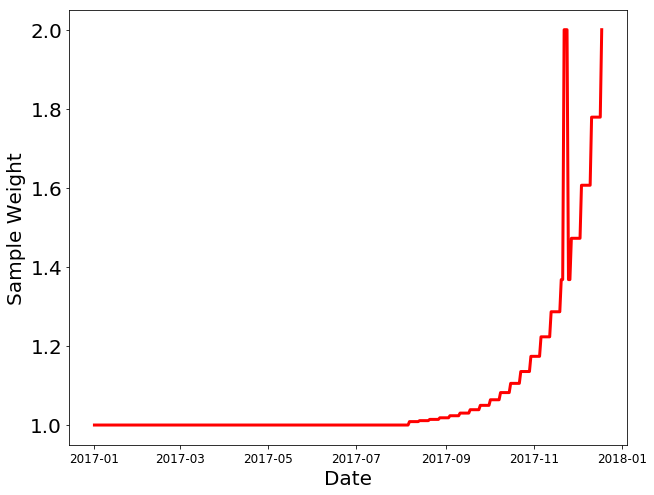

In [56]:
plt.rcParams['figure.figsize'] = [10, 8]
wts_df = get_sample_weights(full_df.index, dataframe=True)
plt.plot(wts_df.index[:-9], wts_df.sample_weight[:-9], linewidth=3, color='r')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Sample Weight', fontsize=20)

import matplotlib.pylab as pylab
params = {'xtick.labelsize':12,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

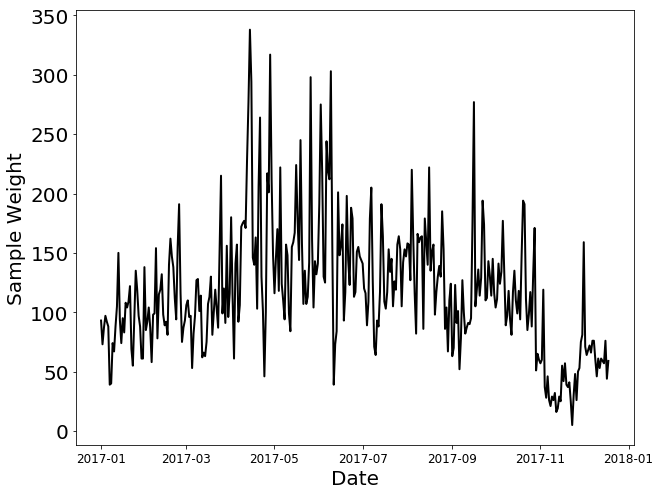

In [54]:
plt.rcParams['figure.figsize'] = [10, 8]
#wts_df = get_sample_weights(full_df.index, dataframe=True)
plt.plot(full_df.index[:-9], full_df.num_clients[:-9], linewidth=2, color='black')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Sample Weight', fontsize=20)

import matplotlib.pylab as pylab
params = {'xtick.labelsize':12,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

In [6]:
# Used to cross-validate models below
class MAPECrossValidator:
    """
    Cross validates arbitrary model using MAPE criterion on
    list of lambdas.
    """
    def __init__(self, model_data, ModelClass, log=False):
        self.model_data = model_data
        self.ModelClass = ModelClass
        self.log = log
    
    def cross_validate(self, lambdas, num_folds=10):
        """
        lambdas: set of regularization parameters to try
        num_folds: number of folds to cross-validate against
        """
        
        self.lambdas = lambdas
        self.cv_scores = []
        X = self.model_data.X
        Y = self.model_data.Y 
        
        beta_init = None
        for lam in self.lambdas:
            
            kf = KFold(n_splits=num_folds, shuffle=True)
            kf.get_n_splits(X)
            
            k_fold_scores = []
            
            f = 1
            for train_index, test_index in kf.split(X):
                CV_X = X.iloc[train_index,:]
                CV_Y = Y.iloc[train_index]
                CV_weights = self.model_data.sample_weights.iloc[train_index]
                
                holdout_X = X.iloc[test_index,:]
                holdout_Y = Y.iloc[test_index]
                holdout_weights = self.model_data.sample_weights.iloc[test_index]
                
                lambda_fold_model = self.ModelClass(
                    regularization=lam,
                    X=CV_X,
                    Y=CV_Y,
                    sample_weights=CV_weights,
                    log = self.log,
                    beta_init=beta_init
                )
                lambda_fold_model.fit()
                beta_init = lambda_fold_model.beta
                
                fold_preds = lambda_fold_model.predict(holdout_X)
                fold_mape = mean_absolute_percentage_error(
                    holdout_Y, fold_preds, sample_weights=holdout_weights
                )
                k_fold_scores.append(fold_mape)
                print("Lambda: {}. Fold: {}. Error: {}".format(lam, f, fold_mape))
                f += 1
                
            lambda_scores = np.mean(k_fold_scores)
            print("LAMBDA AVERAGE: {}".format(lambda_scores))
            self.cv_scores.append(lambda_scores)
        
        # Identify the lambda with the lowest cross-validation error
        self.lambda_star_index = np.argmin(self.cv_scores)
        self.lambda_star = self.lambdas[self.lambda_star_index]

### Linear Model: MAPE objective, with L2 regularization

Predictions are from a simple linear model: $ y_i = X_i \beta $. However, the $\beta$ for this model is found not by using least squares, but by direction minimizing the mean absolute percentage error. We also regularize the $\beta$ parameter by adding an L2 penalty. In particular, the full loss function for this model is given by:

$$ L(\beta) = \frac{100}{N} \sum_{i=1}^N \left| \frac{y_i - X_i\beta}{y_i} \right| + \lambda \sum_{k=1}^K \beta_k^2 $$

Or, in the case that sample weights are provided:

$$ L(\beta) = 100 \left( \sum_{i=1}^N w_i \right)^{-1} \sum_{i=1}^N w_i \left| \frac{y_i - X_i\beta}{y_i} \right| + \lambda \sum_{k=1}^K \beta_k^2 $$

As mentioned, this model is fit using numerical optimization. This means it is much slower to fit, but (as with other quantile regression) there is no analytical solution for the arg-min of the loss function.

# Num Clients Model

In [5]:
# Model specification
features = [
    "num_clients_lag_7", 
    'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat', 'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
    'quarter_q1', 'quarter_q2', 'quarter_q3', 'quarter_q4',
    "federal_holiday", "big_holiday", "big_holiday_before", "big_holiday_after",
    'community_event', 'community_event_count', 'community_gingerbread_express', 'community_holiday_market',
    "wu_temp_high", "wu_temp_high_sq", "wu_precip", "wu_precip_sq", "wu_humid_low", "wu_humid_low_sq", 'wu_wind_avg', 'wu_event_sum', "wu_event_thunderstorm",  
    "bb_game", 'bb_location_away', 'bb_location_home', "bb_ranked_opponent_True", "bb_cumulative_wins"
]

interactions = [
    ('quarter_q4', "num_clients_lag_7"),
    ('quarter_q4', "wu_temp_high"),
    ('quarter_q4', "wu_precip")
]

In [6]:
num_clients_x = get_model_df(full_df, metric='num_clients', col_type="X")
num_clients_y = get_model_df(full_df, metric='num_clients', col_type="Y")
num_clients = ModelData(num_clients_x, Y=num_clients_y, 
                        features=features, interactions=interactions, 
                        sample_weights=get_sample_weights(num_clients_x.index))

In [16]:
lambdas = np.linspace(0.0005, 0.002, 10)
cross_validator = MAPECrossValidator(num_clients, LinearModel_MAPE)
cross_validator.cross_validate(lambdas=lambdas, num_folds=10)

Lambda: 0.0005. Fold: 1
Lambda: 0.0005. Fold: 2
Lambda: 0.0005. Fold: 3
Lambda: 0.0005. Fold: 4
Lambda: 0.0005. Fold: 5
Lambda: 0.0005. Fold: 6
Lambda: 0.0005. Fold: 7
Lambda: 0.0005. Fold: 8
Lambda: 0.0005. Fold: 9
Lambda: 0.0005. Fold: 10
Lambda: 0.0006666666666666666. Fold: 1
Lambda: 0.0006666666666666666. Fold: 2
Lambda: 0.0006666666666666666. Fold: 3
Lambda: 0.0006666666666666666. Fold: 4
Lambda: 0.0006666666666666666. Fold: 5
Lambda: 0.0006666666666666666. Fold: 6
Lambda: 0.0006666666666666666. Fold: 7
Lambda: 0.0006666666666666666. Fold: 8
Lambda: 0.0006666666666666666. Fold: 9
Lambda: 0.0006666666666666666. Fold: 10
Lambda: 0.0008333333333333333. Fold: 1
Lambda: 0.0008333333333333333. Fold: 2
Lambda: 0.0008333333333333333. Fold: 3
Lambda: 0.0008333333333333333. Fold: 4
Lambda: 0.0008333333333333333. Fold: 5
Lambda: 0.0008333333333333333. Fold: 6
Lambda: 0.0008333333333333333. Fold: 7
Lambda: 0.0008333333333333333. Fold: 8
Lambda: 0.0008333333333333333. Fold: 9
Lambda: 0.0008333

In [31]:
# Fit model
clients_model = LinearModel_MAPE(regularization=0.001, X=num_clients.X, Y=num_clients.Y, sample_weights=num_clients.sample_weights)
clients_model.fit(maxiter=500)

In [32]:
# Save model
with open('alexs_models/clients.pickle', 'wb+') as handle:
    pickle.dump(clients_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
# Save test data as CSV
num_clients_test = get_test_X(full_df, num_clients)
num_clients_test.to_csv("my_data/test_data/clients.csv")

In [35]:
# Predict on test data
clients_model.predict(num_clients_test)

date
2017-12-21     52.383986
2017-12-22     63.126614
2017-12-23    104.144964
2017-12-24      1.934931
2017-12-25     10.406669
2017-12-26     14.286221
2017-12-27     49.219011
dtype: float64

# Num Sessions Model

In [66]:
# Define model
sessions_features = [
    "num_sessions_lag_7", 
    'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat', 'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
    'quarter_q1', 'quarter_q2', 'quarter_q3', 'quarter_q4',
    "federal_holiday", "big_holiday", "big_holiday_before", "big_holiday_after",
    'community_event', 'community_event_count', 'community_gingerbread_express', 'community_holiday_market',
    "wu_temp_high", "wu_temp_high_sq", "wu_precip", "wu_precip_sq", "wu_humid_low", "wu_humid_low_sq", 'wu_wind_avg', 'wu_event_sum', "wu_event_thunderstorm",  
    "bb_game", 'bb_location_away', 'bb_location_home', "bb_ranked_opponent_True", "bb_cumulative_wins"
]

sessions_interactions = [
    ('quarter_q4', "num_sessions_lag_7"),
    ('quarter_q4', "wu_temp_high"),
    ('quarter_q4', "wu_precip")
]

# Get training data object
num_sessions_x = get_model_df(full_df, metric='num_sessions', col_type="X")
num_sessions_y = get_model_df(full_df, metric='num_sessions', col_type="Y")
num_sessions = ModelData(num_sessions_x, Y=num_sessions_y, 
                         features=sessions_features, interactions=sessions_interactions,
                        sample_weights=get_sample_weights(num_sessions_x.index))

In [67]:
# Save test data as CSV
num_sessions_test = get_test_X(full_df, num_sessions)
num_sessions_test.to_csv("my_data/test_data/sessions.csv")

In [20]:
lambdas = list(np.linspace(1e-6, 1e-5, 5)) + list(np.linspace(2e-5, 1e-4, 5)) + list(np.linspace(2e-4, 1e-3, 5)) + list(np.linspace(2e-3, 1e-2, 5)) + list(np.linspace(2e-2, 1e-1, 5))
cross_validator2 = MAPECrossValidator(num_sessions, LinearModel_MAPE, log=True)
cross_validator2.cross_validate(lambdas=lambdas, num_folds=5)

Lambda: 1e-06. Fold: 1. MAPE: 65520053.75254224
Lambda: 1e-06. Fold: 2. MAPE: 37.76113727406676
Lambda: 1e-06. Fold: 3. MAPE: 29.1340379836136
Lambda: 1e-06. Fold: 4. MAPE: 24.816585661389045
Lambda: 1e-06. Fold: 5. MAPE: 37.72891155560488
LAMBDA AVERAGE: 13104036.638642944
Lambda: 3.2500000000000002e-06. Fold: 1. MAPE: 26.033993530207912
Lambda: 3.2500000000000002e-06. Fold: 2. MAPE: 22.65607500745215
Lambda: 3.2500000000000002e-06. Fold: 3. MAPE: 67.32592124344657
Lambda: 3.2500000000000002e-06. Fold: 4. MAPE: 37.57267984189496
Lambda: 3.2500000000000002e-06. Fold: 5. MAPE: 43.1597356107555
LAMBDA AVERAGE: 39.34968104675142
Lambda: 5.5e-06. Fold: 1. MAPE: 30.633799179320388
Lambda: 5.5e-06. Fold: 2. MAPE: 38.81858362448657
Lambda: 5.5e-06. Fold: 3. MAPE: 39.74750060202007
Lambda: 5.5e-06. Fold: 4. MAPE: 34.734098873876086
Lambda: 5.5e-06. Fold: 5. MAPE: 26.632413213340897
LAMBDA AVERAGE: 34.1132790986088
Lambda: 7.75e-06. Fold: 1. MAPE: 42.66473790630546
Lambda: 7.75e-06. Fold: 2. MA

In [23]:
# Fit model
sessions_model_linear = LinearModel_MAPE(
    regularization=0.002,
    X=num_sessions.X,
    Y=num_sessions.Y,
    sample_weights=num_sessions.sample_weights,
    log=True
)
sessions_model_linear.fit(maxiter=500)
sessions_model_linear.true_error()

25.080341807618609

In [18]:
# Fit Model
sessions_model_rf = RF_RegressionModel(X=num_sessions.X, Y=num_sessions.Y, sample_weights=num_sessions.sample_weights)
sessions_model_rf.fit()
sessions_model_rf.error()

In [24]:
# Choose RF or linear model
sessions_model = sessions_model_linear

In [25]:
# Save model
with open('alexs_models/sessions.pickle', 'wb+') as handle:
    pickle.dump(sessions_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# Generate predictions
sessions_model.predict(num_sessions_test)

date
2017-12-21     489.553361
2017-12-22     533.863928
2017-12-23    1078.721559
2017-12-24     125.100719
2017-12-25      41.923848
2017-12-26     354.248044
2017-12-27     480.210069
dtype: float64

# Usage Model
This model is slightly more complicated. I am using the same linear MAPE model as above to predict *daily* traffic. However, predictions must be made in terms of hours. So I am using an ad hoc model of hourly traffic distribution, based on the few weeks before the prediction period.

To obtain my final predictions, I predict the daily traffic for each of the test days, then distribute this traffic according to the average distribution for each day of the week in the weeks leading up to the holdout.

In [68]:
# Define model features
traffic_features = [
    "total_traffic_lag_7", 
    'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat', 'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
    'quarter_q1', 'quarter_q2', 'quarter_q3', 'quarter_q4',
    "federal_holiday", "big_holiday", "big_holiday_before", "big_holiday_after",
    'community_event', 'community_event_count', 'community_gingerbread_express', 'community_holiday_market',
    "wu_temp_high", "wu_temp_high_sq", "wu_precip", "wu_precip_sq", "wu_humid_low", "wu_humid_low_sq", 'wu_wind_avg', 'wu_event_sum', "wu_event_thunderstorm",  
    "bb_game", 'bb_location_away', 'bb_location_home', "bb_ranked_opponent_True", "bb_cumulative_wins"
]

traffic_interactions = [
    ('quarter_q4', "total_traffic_lag_7"),
    ('quarter_q4', "wu_temp_high"),
    ('quarter_q4', "wu_precip")
]

In [69]:
# Get training data
traffic_x = get_model_df(full_df, metric='total_traffic', col_type="X")
traffic_y = get_model_df(full_df, metric='total_traffic', col_type="Y")
traffic_data = ModelData(traffic_x, Y=traffic_y, features=traffic_features, interactions=traffic_interactions, sample_weights=get_sample_weights(traffic_x.index))

In [70]:
# Get test data and save to CSV
traffic_test = get_test_X(full_df, traffic_data)
traffic_test.to_csv("my_data/test_data/usage.csv")

In [45]:
#lambdas = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]
lambdas = list(np.linspace(1e-6, 1e-5, 5)) + list(np.linspace(2e-5, 1e-4, 5)) + list(np.linspace(2e-4, 1e-3, 5)) + list(np.linspace(2e-3, 1e-2, 5)) + list(np.linspace(2e-2, 1e-1, 5))
cross_validator3 = MAPECrossValidator(traffic_data, LinearModel_MAPE, log=True)
cross_validator3.cross_validate(lambdas=lambdas, num_folds=10)

Lambda: 1e-06. Fold: 1. MAPE: 94448864.98816858
Lambda: 1e-06. Fold: 2. MAPE: 71.26812675147829
Lambda: 1e-06. Fold: 3. MAPE: 46.49172485749762
Lambda: 1e-06. Fold: 4. MAPE: 45.437966046134065
Lambda: 1e-06. Fold: 5. MAPE: 61.471375297804784
Lambda: 1e-06. Fold: 6. MAPE: 406.8725956101221
Lambda: 1e-06. Fold: 7. MAPE: 86.2688919755738
Lambda: 1e-06. Fold: 8. MAPE: 63.829365006211816
Lambda: 1e-06. Fold: 9. MAPE: 45.169749916362015
Lambda: 1e-06. Fold: 10. MAPE: 62.27372445744629
LAMBDA AVERAGE: 9444975.407168848
Lambda: 2.8000000000000003e-06. Fold: 1. MAPE: 66.12418799782397
Lambda: 2.8000000000000003e-06. Fold: 2. MAPE: 87.09467508206227
Lambda: 2.8000000000000003e-06. Fold: 3. MAPE: 95.14811603112246
Lambda: 2.8000000000000003e-06. Fold: 4. MAPE: 35.459465147515395
Lambda: 2.8000000000000003e-06. Fold: 5. MAPE: 782.0745158870843
Lambda: 2.8000000000000003e-06. Fold: 6. MAPE: 73.5392199121617
Lambda: 2.8000000000000003e-06. Fold: 7. MAPE: 74.3145255936792
Lambda: 2.8000000000000003e-

Lambda: 0.0008. Fold: 3. MAPE: 84.46341383641341
Lambda: 0.0008. Fold: 4. MAPE: 40.0811869985874
Lambda: 0.0008. Fold: 5. MAPE: 81.10092014808464
Lambda: 0.0008. Fold: 6. MAPE: 54.866023749358234
Lambda: 0.0008. Fold: 7. MAPE: 114.16638023417802
Lambda: 0.0008. Fold: 8. MAPE: 38.08395416347673
Lambda: 0.0008. Fold: 9. MAPE: 38.87714423719511
Lambda: 0.0008. Fold: 10. MAPE: 67.59237936209878
LAMBDA AVERAGE: 64.74298233897515
Lambda: 0.001. Fold: 1. MAPE: 84.27941451482964
Lambda: 0.001. Fold: 2. MAPE: 59.931031617651655
Lambda: 0.001. Fold: 3. MAPE: 45.76587471553909
Lambda: 0.001. Fold: 4. MAPE: 510.76662897783075
Lambda: 0.001. Fold: 5. MAPE: 49.05298852390015
Lambda: 0.001. Fold: 6. MAPE: 56.22779814355505
Lambda: 0.001. Fold: 7. MAPE: 87.23164643663367
Lambda: 0.001. Fold: 8. MAPE: 43.16697343634881
Lambda: 0.001. Fold: 9. MAPE: 38.31065213765236
Lambda: 0.001. Fold: 10. MAPE: 34.53188479723709
LAMBDA AVERAGE: 100.92648933011783
Lambda: 0.002. Fold: 1. MAPE: 51.301269527355366
Lambd

In [10]:
traffic_model_linear = LinearModel_MAPE(
    regularization=0.0008,
    X=traffic_data.X,
    Y=traffic_data.Y,
    sample_weights=traffic_data.sample_weights,
    log=True
)
traffic_model_linear.fit(maxiter=500)

In [59]:
# Fit first level model
traffic_model_rf = RF_RegressionModel(X=traffic_data.X, Y=traffic_data.Y, sample_weights=traffic_data.sample_weights)
traffic_model_rf_model.fit()

In [11]:
# Choose between linear & RF model 
traffic_model = traffic_model_linear

In [12]:
# Save model
with open('alexs_models/usage.pickle', 'wb+') as handle:
    pickle.dump(traffic_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Take RF model and predict hourly usage based on
# historical distribution
hourly_proportions = pd.read_csv("my_data/training_data/hourly_proportions.csv", index_col=0)
traffic_model = UsagePredictor(traffic_model, hourly_proportions)

In [16]:
# Predict on test data:
p = traffic_model.predict(traffic_test)

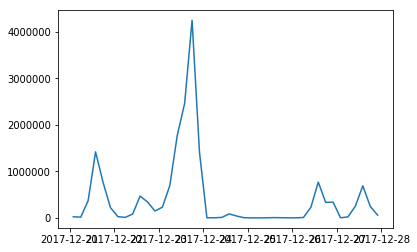

In [17]:
plt.plot(p.index, p)

# Command line usage

To get predictions from command line, navigate to the directory with "predict.py" and performt the following operations:

In [80]:
!python predict.py --help

usage: predict.py [-h] -v VARIABLE -x PREDICTORS

This script generates predictions for each of the three variables

optional arguments:
  -h, --help            show this help message and exit
  -v VARIABLE, --variable VARIABLE
                        Which variable to predict: must be one of clients,
                        sessions, or usage
  -x PREDICTORS, --predictors PREDICTORS
                        Input data to generate predictions. Data must be
                        formatted properly (see Notebook Walkthrough file).
                        Must either be a range of row numbers from the
                        training data (e.g., "10,20") or the word "test" to
                        generate predictions on test data.


In [80]:
!python predict.py -v clients -x test

2017-12-21 00:00:00, 52.990122007837016
2017-12-22 00:00:00, 58.871422274857665
2017-12-23 00:00:00, 95.18388950803094
2017-12-24 00:00:00, 7.2867073673802425
2017-12-25 00:00:00, 13.192190612475803
2017-12-26 00:00:00, 22.22350325258874
2017-12-27 00:00:00, 59.23973479271851


In [79]:
!python predict.py -v sessions -x test

2017-12-21 00:00:00, 474.57386692844625
2017-12-22 00:00:00, 466.1642332125996
2017-12-23 00:00:00, 898.0292761780591
2017-12-24 00:00:00, 135.19420097020517
2017-12-25 00:00:00, 45.93816026517508
2017-12-26 00:00:00, 422.5905109203296
2017-12-27 00:00:00, 615.0959603828734


In [81]:
!python predict.py -v usage -x test

2017-12-21 02:00:00, 24344.931149960492
2017-12-21 06:00:00, 15677.509831229172
2017-12-21 10:00:00, 359869.0085848941
2017-12-21 14:00:00, 1379154.3082297419
2017-12-21 18:00:00, 749092.2718941673
2017-12-21 22:00:00, 216866.34250840067
2017-12-22 02:00:00, 22024.883511559136
2017-12-22 06:00:00, 9274.999759480148
2017-12-22 10:00:00, 66524.5975179828
2017-12-22 14:00:00, 374547.477863401
2017-12-22 18:00:00, 272893.157844743
2017-12-22 22:00:00, 118444.55295714403
2017-12-23 02:00:00, 157884.55661310809
2017-12-23 06:00:00, 475702.28422097233
2017-12-23 10:00:00, 1213408.1160556294
2017-12-23 14:00:00, 1688696.8830933145
2017-12-23 18:00:00, 2913674.9421333103
2017-12-23 22:00:00, 966415.275352074
2017-12-24 02:00:00, 2943.6942442262957
2017-12-24 06:00:00, 3051.226236675968
2017-12-24 10:00:00, 12199.78773071331
2017-12-24 14:00:00, 94100.59177020547
2017-12-24 18:00:00, 44544.54715327313
2017-12-24 22:00:00, 5233.134062937265
2017-12-25 02:00:00, 170.97013611323572
2017-12-25 06:00

In [14]:
X = num_clients.X_raw
Y = num_clients.Y

In [8]:
%load_ext rpy2.ipython

In [15]:
%%R -i X,Y
df = cbind(X,Y)
head(df)

                    bb_cumulative_wins bb_game bb_location_away
2017-01-08 00:00:00                 12       1                0
2017-01-09 00:00:00                  0       0                0
2017-01-10 00:00:00                  0       0                0
2017-01-11 00:00:00                  0       0                0
2017-01-12 00:00:00                  0       0                0
2017-01-13 00:00:00                  0       0                0
                    bb_location_home bb_ranked_opponent_True big_holiday
2017-01-08 00:00:00                1                       0           0
2017-01-09 00:00:00                0                       0           0
2017-01-10 00:00:00                0                       0           0
2017-01-11 00:00:00                0                       0           0
2017-01-12 00:00:00                0                       0           0
2017-01-13 00:00:00                0                       0           0
                    big_holiday_after big

In [17]:
%%R

model = lm(Y ~ ., data=df)
summary(model)


Call:
lm(formula = Y ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-118.860  -17.797   -1.848   15.679  123.876 

Coefficients: (2 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -1.027e+02  3.719e+01  -2.761 0.006110 ** 
bb_cumulative_wins              1.706e+00  1.203e+00   1.419 0.157045    
bb_game                        -2.304e+01  2.772e+01  -0.831 0.406430    
bb_location_away               -5.353e-01  2.037e+01  -0.026 0.979054    
bb_location_home               -3.040e+00  2.015e+01  -0.151 0.880196    
bb_ranked_opponent_True        -7.809e+00  1.458e+01  -0.535 0.592740    
big_holiday                    -3.386e+01  2.886e+01  -1.173 0.241687    
big_holiday_after              -5.811e+01  3.865e+01  -1.504 0.133694    
big_holiday_before             -3.889e+01  3.282e+01  -1.185 0.236920    
community_event                 6.469e+00  1.126e+01   0.574 0